In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

print("Set device to:", device)

Set device to: cuda


In [2]:
# Dummy dataset creator:
class Dummy_PMSSMDataset(Dataset):
    def __init__(self, n_samples=10000):
        super().__init__()
        self.x = torch.randn(n_samples, 19)

        # Dummy "physics-inspired" target
        # Nonlinear function + noise
        self.y = (
            torch.sum(self.x[:, :5] ** 2, dim=1)
            + torch.sin(self.x[:, 5:10]).sum(dim=1)
            + 0.1 * torch.randn(n_samples)
        )
        self.y = self.y.unsqueeze(1)  # (N, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [3]:
# Create real dataset:
import uproot

# Open ROOT file
file = uproot.open("data/ntuple.18192176.0.root")

# Access the tree
tree = file["susy"]

# Print branches starting with "IN_"
print("Branches in 'susy' starting with 'IN_':")
print("-" * 40)

for branch_name in tree.keys():
    if branch_name.startswith("IN_") or branch_name.startswith("MO_"):
        if "err" in branch_name: continue
        print(f"{branch_name}: {tree[branch_name].array()}")
        
branches = ["IN_meL", "IN_meR", "IN_mtauL", "IN_mtauR", "IN_mqL1", "IN_muR", "IN_mdR", "IN_mqL3", "IN_mtR", "IN_mbR", "IN_M_1", "IN_M_2", "IN_mu", "IN_M_3", "IN_At", "IN_Ab", "IN_Atau", "IN_mA", "IN_tanb"]
print(f"Overall: n_branches = {len(branches)}")

arrays = tree.arrays(branches, library="np")
print(arrays)

branch_target = ["MO_Omega"]
array_target = tree.arrays(branch_target, library="np")
print("array_target:", array_target)

Branches in 'susy' starting with 'IN_':
----------------------------------------
IN_M_1: [632, -333, 1.55e+03, 595, -581, ..., -12.5, -1.76e+03, 1.02e+03, -1.24e+03]
IN_M_2: [1.3e+03, -1.4e+03, 369, -634, ..., -1.63e+03, 1.9e+03, -1.55e+03, -70.2]
IN_M_3: [2.39e+03, 1.34e+03, 3.98e+03, 1.62e+03, ..., 1.79e+03, 2.17e+03, 1.31e+03]
IN_At: [5.56e+03, -180, 659, -6.16e+03, ..., -3.73e+03, -550, 4.84e+03, 7.76e+03]
IN_Ab: [-669, -391, -1.14e+03, -1.5e+03, 1.8e+03, ..., -567, 1.9e+03, -750, -426]
IN_Atau: [412, -935, 881, 638, -1.37e+03, ..., -1.1e+03, 1.9e+03, 571, -60.2, -1.85e+03]
IN_mu: [1.4e+03, 1.71e+03, -747, 691, 1.8e+03, ..., 1.51e+03, -634, 1.18e+03, 4.19]
IN_tanb: [12.2, 20.3, 30.4, 18.4, 52.4, 41, ..., 48.1, 28.4, 4.07, 18.8, 51.6, 11.7]
IN_mA: [2.82e+03, 644, 3.79e+03, 3.95e+03, ..., 2.06e+03, 2.35e+03, 1.65e+03, 4.89e+03]
IN_meL: [1e+04, 1e+04, 1e+04, 1e+04, 1e+04, ..., 1e+04, 1e+04, 1e+04, 1e+04, 1e+04]
IN_mmuL: [1e+04, 1e+04, 1e+04, 1e+04, 1e+04, ..., 1e+04, 1e+04, 1e+04, 1e+

(array([6109.,  430.,  110.,   51.,   43.,   46.,   37.,   27.,   27.,
          30.]),
 array([1.52736902e-07, 9.97001380e-02, 1.99400112e-01, 2.99100101e-01,
        3.98800075e-01, 4.98500049e-01, 5.98200083e-01, 6.97900057e-01,
        7.97600031e-01, 8.97300005e-01, 9.96999979e-01]),
 <BarContainer object of 10 artists>)

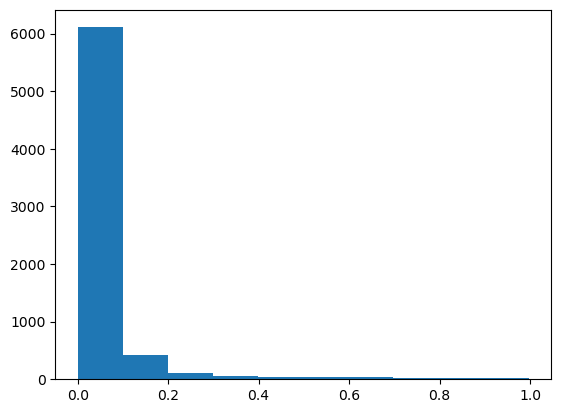

In [4]:
class PMSSMDataset(Dataset):
    def __init__(self, n_samples=10_000):
        super().__init__()
        
        # create numpy array from dictionary:
        X = np.column_stack([arrays[branch] for branch in branches])
        # convert to tensor:
        X = torch.from_numpy(X).float()
        
        # print(X.shape)

        # normalise:
        mean = X.mean(dim=0)
        std  = X.std(dim=0) + 1e-8

        X_norm = (X - mean) / std
        self.x = X_norm

        # Define target
        Y = array_target["MO_Omega"]
        # prune -1 values:
        self.x = self.x[ Y != -1. ]
        Y = Y[ Y != -1. ]        
        
        # temporary?: prune away Y values 1 and above:
        # Y[ Y > 10 ] = 10
        self.x = self.x[ Y < 1 ]
        Y = Y[ Y < 1 ]
        
        Y = torch.from_numpy(Y).float()

        # normalise Y:
        global mean_Y
        global std_Y
        mean_Y = Y.mean(dim=0)
        std_Y = Y.std(dim=0) + 1e-8
        
        Y_norm = (Y - mean_Y) / std_Y
        self.y = Y_norm

        self.y = self.y.unsqueeze(1)  # (N, 1)
        
        # prune X and Y to match n_samples:
        self.x = self.x[:n_samples]
        self.y = self.y[:n_samples]
        
        # print("self.x.shape:", self.x.shape)
        # print("self.y.shape:", self.y.shape)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = PMSSMDataset()

plt.hist(dataset.y * std_Y + mean_Y)

In [5]:
class PMSSMTransformer(nn.Module):
    def __init__(
        self,
        n_params=19,
        d_model=64,
        nhead=8,
        num_layers=4,
        dim_feedforward=256,
        dropout=0.1,
    ):
        super().__init__()

        # Embed each scalar parameter
        self.input_embed = nn.Linear(1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1),
        )

    def forward(self, x):
        # x: (batch, 19)
        x = x.unsqueeze(-1)               # (batch, 19, 1)
        x = self.input_embed(x)           # (batch, 19, d_model)

        x = self.encoder(x)               # (batch, 19, d_model)

        x = x.mean(dim=1)                 # pool over parameters
        y = self.regressor(x)             # (batch, 1)

        return y


In [6]:
def train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device="cpu",
    epochs=30,
):
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                val_loss += loss.item() * x.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch:03d} | "
            f"Train MSE = {train_loss:.6f} | "
            f"Val MSE = {val_loss:.6f}"
        )

    return train_losses, val_losses


In [7]:
# dataset = PMSSMDataset(n_samples=30)
dataset = PMSSMDataset(n_samples=10_000)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=256, shuffle=False
)


In [8]:
model = PMSSMTransformer(
    d_model=64,
    nhead=8,
    num_layers=4,
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_losses, val_losses = train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device=device,
    epochs=5_000,
)

Epoch 000 | Train MSE = 0.991837 | Val MSE = 1.205248
Epoch 001 | Train MSE = 0.980104 | Val MSE = 1.199976
Epoch 002 | Train MSE = 0.980155 | Val MSE = 1.198840
Epoch 003 | Train MSE = 0.978854 | Val MSE = 1.199309
Epoch 004 | Train MSE = 0.975774 | Val MSE = 1.197525
Epoch 005 | Train MSE = 0.975838 | Val MSE = 1.198272
Epoch 006 | Train MSE = 0.974963 | Val MSE = 1.195112
Epoch 007 | Train MSE = 0.977495 | Val MSE = 1.195385
Epoch 008 | Train MSE = 0.978679 | Val MSE = 1.205363
Epoch 009 | Train MSE = 0.972976 | Val MSE = 1.193189
Epoch 010 | Train MSE = 0.971564 | Val MSE = 1.195190
Epoch 011 | Train MSE = 0.971444 | Val MSE = 1.195004
Epoch 012 | Train MSE = 0.974994 | Val MSE = 1.222382
Epoch 013 | Train MSE = 0.972771 | Val MSE = 1.194492
Epoch 014 | Train MSE = 0.972103 | Val MSE = 1.196192
Epoch 015 | Train MSE = 0.972748 | Val MSE = 1.207536
Epoch 016 | Train MSE = 0.976210 | Val MSE = 1.197593
Epoch 017 | Train MSE = 0.972343 | Val MSE = 1.196191
Epoch 018 | Train MSE = 0.97

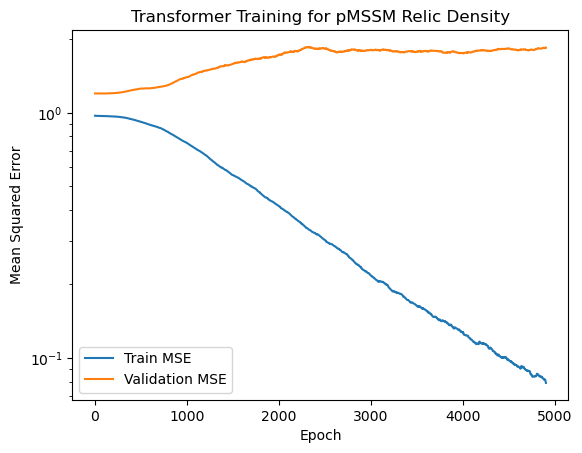

In [9]:
def rolling_average(x, window=100):
    x = np.asarray(x)
    return np.convolve(x, np.ones(window) / window, mode="valid")

plt.figure()
plt.plot(rolling_average(train_losses), label="Train MSE")
plt.plot(rolling_average(val_losses), label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Transformer Training for pMSSM Relic Density")
plt.yscale('log')
plt.show()

# Compare random points

In [10]:
import random

def compare_random_predictions(model, mode='validation', device="cpu", n_points=3):
    model.eval()
    model.to(device)

    if mode == 'validation':
        print("\nComparison on random validation points:")
        dataset = val_dataset
    elif mode == 'train':
        print("\nComparison on random training points:")
        dataset = train_dataset
    else: raise ValueError("Unsupported mode! Should be validation, train.")
        
    # print(len(dataset), n_points)
    indices = random.sample(range(len(dataset)), n_points)

    print("-" * 90)
    print(f"{'Index':>6} | {'True Ωh (norm.)²':>20} | {'Predicted Ωh (norm.)²':>23} | {'True Ωh²':>12} | {'Predicted Ωh²':>15}")
    print("-" * 90)

    with torch.no_grad():
        for idx in indices:
            x, y_true = dataset[idx]
            x = x.unsqueeze(0).to(device)      # (1, 19)
            y_pred = model(x).cpu().item()

            # revert normalisation:
            # Y_norm = (Y - self.mean_Y) / self.std_Y
            y_true_nonorm = y_true * std_Y + mean_Y
            y_pred_nonorm = y_pred * std_Y + mean_Y

            print(
                f"{idx:6d} | "
                f"{y_true.item():20.6f} | "
                f"{y_pred:23.6f} | "
                f"{y_true_nonorm.item():12.6f} | "
                f"{y_pred_nonorm:15.6f}"
            )

    print("-" * 90)


In [11]:
# compare training points
compare_random_predictions(
    model,
    mode='train',
    device=device,
    n_points=10,
)


Comparison on random training points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
   853 |            -0.382380 |                0.025994 |     0.003960 |        0.054733
  4659 |            -0.258195 |               -0.321378 |     0.019400 |        0.011544
  2245 |            -0.384873 |               -0.297068 |     0.003650 |        0.014567
  3134 |             0.470509 |                0.070007 |     0.110000 |        0.060205
  2657 |             0.607242 |                0.405450 |     0.127000 |        0.101911
  1842 |            -0.356722 |               -0.405845 |     0.007150 |        0.001043
  5965 |            -0.380369 |               -0.590338 |     0.004210 |       -0.021895
  1264 |            -0.409807 |               -0.289321 |     0.000

In [12]:
# compare validation points:
compare_random_predictions(
    model,
    mode='validation',
    device=device,
    n_points=3,
)



Comparison on random validation points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
   493 |            -0.396053 |               -0.081985 |     0.002260 |        0.041308
   614 |            -0.291171 |                1.155022 |     0.015300 |        0.195106
   622 |            -0.378600 |                5.725142 |     0.004430 |        0.763310
------------------------------------------------------------------------------------------


In [31]:
import torch
import matplotlib.pyplot as plt

def scatter_true_vs_pred(
    model,
    mode="validation",
    device="cpu",
    denormalize=True,
):
    model.eval()
    model.to(device)

    if mode == "validation":
        dataset = val_dataset
        title = "Validation set"
    elif mode == "train":
        dataset = train_dataset
        title = "Training set"
    else:
        raise ValueError("Unsupported mode! Should be validation or train.")

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for x, y_true in dataset:
            x = x.unsqueeze(0).to(device)   # (1, n_features)
            y_pred = model(x).cpu().item()

            if denormalize:
                y_true_val = (y_true * std_Y + mean_Y).item()
                y_pred_val = y_pred * std_Y + mean_Y
            else:
                y_true_val = y_true.item()
                y_pred_val = y_pred

            y_true_all.append(y_true_val)
            y_pred_all.append(y_pred_val)

    # --- plot ---
    plt.figure()
    plt.scatter(y_true_all, y_pred_all, alpha=0.5, color = 'orange' if mode == 'validation' else None)
    plt.plot(
        [min(y_true_all), max(y_true_all)],
        [min(y_true_all), max(y_true_all)],
        linestyle='--',
        color='grey'
    )
    plt.xlabel("True Ωh²")
    plt.ylabel("Predicted Ωh²")
    plt.title(f"True vs Predicted Ωh² ({title})")
    plt.tight_layout()
    plt.show()


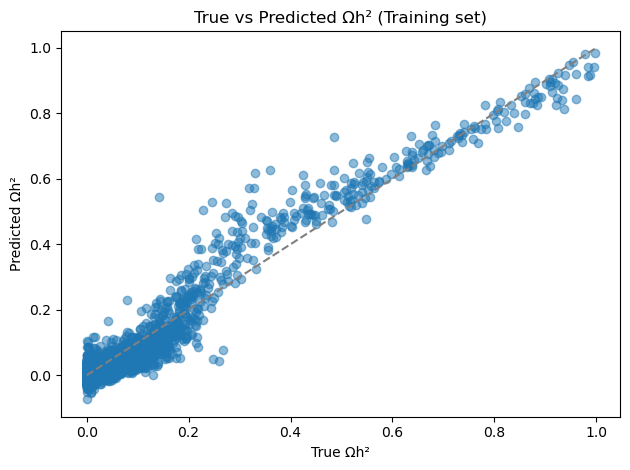

In [32]:
scatter_true_vs_pred(
    model,
    mode='train',
    device=device
)

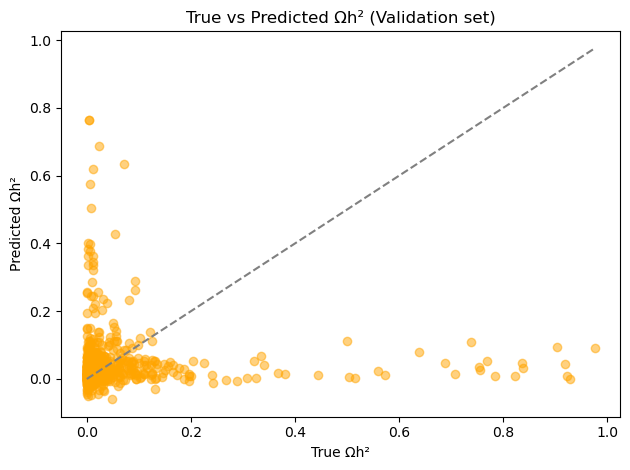

In [33]:
scatter_true_vs_pred(
    model,
    mode='validation',
    device=device
)